In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')

import scipy.stats as stats # For Statistical Tests
from statsmodels.api import OLS #OLS Purpose

from sklearn.metrics import f1_score, classification_report, roc_auc_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import LogisticRegression
# import function to perform feature selection
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
plt.rcParams['figure.figsize'] = [15,8]

In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
from matplotlib.colors import ListedColormap

In [4]:
df_orders = pd.read_csv('orders.csv')
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train = pd.read_csv('order_products__train.csv')
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
df_products = pd.read_csv('products.csv')
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
df_aisles = pd.read_csv('aisles.csv')
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
df_departments = pd.read_csv('departments.csv')
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [13]:
df = pd.read_csv('instacart_data_for_submission.csv',index_col= 0)
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2333802,68,prior,1,5,10,30.0,39275,1,0,Organic Blueberries,123,4,produce,packaged vegetables fruits
1,2333802,68,prior,1,5,10,30.0,5991,2,0,Bok Choy,83,4,produce,fresh vegetables
2,2333802,68,prior,1,5,10,30.0,26384,3,0,Large Brown Eggs,86,16,dairy eggs,eggs
3,2333802,68,prior,1,5,10,30.0,47209,4,0,Organic Hass Avocado,24,4,produce,fresh fruits
4,2333802,68,prior,1,5,10,30.0,40706,5,0,Organic Grape Tomatoes,123,4,produce,packaged vegetables fruits


In [14]:
df.shape

(1582855, 15)

### Feature engineering

In [15]:
#Feature 1
#Counts the number of orders for each user id
order_count_per_user = df.groupby('user_id')['order_id'].nunique().reset_index()
order_count_per_user.rename(columns={'order_id':'order_count_per_user'},inplace=True)
order_count_per_user.head(10)

,user_id,order_count_per_user
0,68,6
1,74,5
2,109,6
3,131,9
4,142,45
5,173,44
6,184,11
7,200,9
8,237,8
9,255,4


In [16]:
df= pd.merge(df, order_count_per_user, on='user_id', how='left')

In [17]:
#Feature 2
#Counts the number of unique products ordered by each user
unique_prod_each_user = df.groupby('user_id')['product_id'].nunique().reset_index()
unique_prod_each_user.rename(columns={'product_id':'unique_prod_each_user'},inplace=True)
unique_prod_each_user.head(10)

,user_id,unique_prod_each_user
0,68,51
1,74,42
2,109,50
3,131,25
4,142,70
5,173,239
6,184,72
7,200,88
8,237,56
9,255,49


In [18]:
df = pd.merge(df, unique_prod_each_user, on='user_id', how='left')

In [19]:
#Feature 3
# Average number of reorders each user does
avg_reorders_per_user= df.groupby('user_id')['reordered'].mean().reset_index()
avg_reorders_per_user.rename(columns={'reordered':'user_reorder_ratio'},inplace=True)

avg_reorders_per_user.head()

,user_id,user_reorder_ratio
0,68,0.271429
1,74,0.125000
2,109,0.275362
3,131,0.576271
4,142,0.809783


In [20]:
df= pd.merge(df, avg_reorders_per_user, on='user_id', how='left')

In [21]:
#Feature 4
# Average number of reorders for each product
avg_reorders_per_product= df.groupby('product_id')['reordered'].mean().reset_index()
avg_reorders_per_product.rename(columns={'reordered':'product_reorder_rate'},inplace=True)

avg_reorders_per_product.head()


,product_id,product_reorder_rate
0,1,0.677686
1,2,0.200000
2,3,0.750000
3,4,0.250000
4,8,0.000000


In [22]:
df= pd.merge(df, avg_reorders_per_product, on='product_id', how='left')

In [23]:
df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'department', 'aisle', 'order_count_per_user',
       'unique_prod_each_user', 'user_reorder_ratio', 'product_reorder_rate'],
      dtype='object')

In [24]:
#Feature 6
#Average number of unique products each user orders
avg_unique_prod_user = df.groupby('user_id')['unique_prod_each_user'].mean().reset_index()
avg_unique_prod_user.rename(columns={'unique_prod_each_user':'avg_unique_prod_user'},inplace=True)
avg_unique_prod_user.head()

,user_id,avg_unique_prod_user
0,68,51.0
1,74,42.0
2,109,50.0
3,131,25.0
4,142,70.0


In [25]:
df= pd.merge(df, avg_unique_prod_user, on='user_id', how='left')

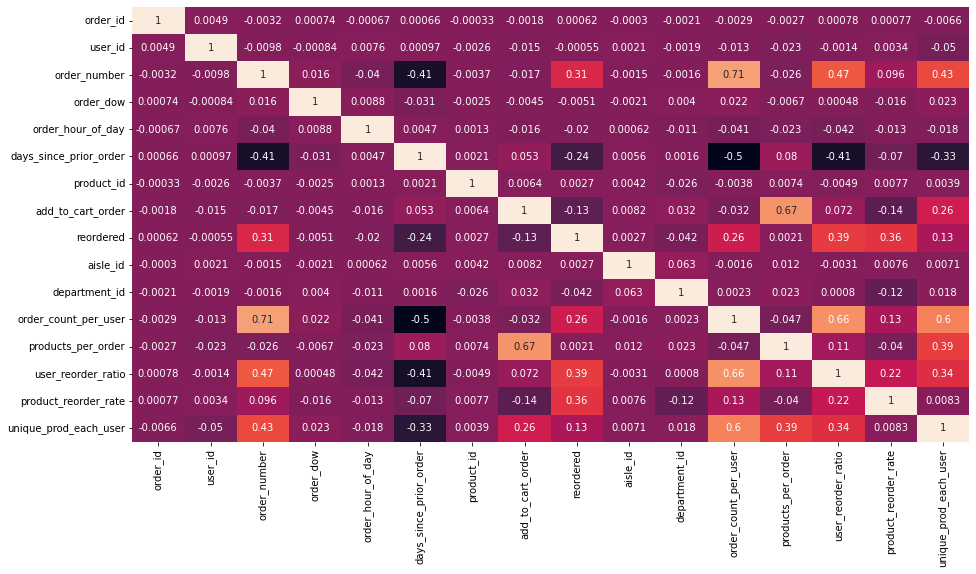

In [183]:
sns.heatmap(df.corr(),annot = True,cbar = False);

In [65]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df[['order_dow']]).toarray()
items = [f'{"order_dow"}_{item}' for item in encoder.categories_[0]]
df[items] = onehotarray

In [66]:
df[items]

,order_dow_0,order_dow_1,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
1582850,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1582851,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1582852,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1582853,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
#Feature 7
#How frequently a user has reorderd a particular product on a saturday?
day0_reorder_freq_user = df.groupby(['user_id','product_id','order_dow_0'])['reordered'].size()
day0_reorder_freq_user = day0_reorder_freq_user/df.groupby(["user_id",'product_id']).size()
day0_reorder_freq_user = day0_reorder_freq_user.reset_index(name = 'day0_reorder_rate_user')

day0_reorder_freq_user.head(10)

,user_id,product_id,order_dow_0,day0_reorder_rate_user
0,68,1025,0.0,1.0
1,68,5479,0.0,1.0
2,68,5652,0.0,1.0
3,68,5991,0.0,1.0
4,68,6649,0.0,1.0
5,68,7398,0.0,1.0
6,68,7948,0.0,1.0
7,68,8436,0.0,1.0
8,68,8656,0.0,1.0
9,68,10644,0.0,1.0


In [68]:
df= pd.merge(df,day0_reorder_freq_user, on=['user_id','product_id','order_dow_0'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,user_reorder_ratio,product_reorder_rate,order_dow_0,order_dow_1,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,day0_reorder_rate_user
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,0.271429,0.641656,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,0.271429,0.485804,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,0.271429,0.635231,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,0.271429,0.790203,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,0.271429,0.662503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,0.271429,0.571429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,0.271429,0.698603,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,0.271429,0.476923,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,0.271429,0.570131,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,0.271429,0.519608,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [69]:
#Feature 8
#How frequently a user has reorderd a particular product on a sunday?
day1_reorder_freq_user = df.groupby(['user_id','product_id','order_dow_1'])['reordered'].size()
day1_reorder_freq_user = day1_reorder_freq_user/df.groupby(["user_id",'product_id']).size()
day1_reorder_freq_user = day1_reorder_freq_user.reset_index(name = 'day1_reorder_rate_user')

day1_reorder_freq_user.head(10)

,user_id,product_id,order_dow_1,day1_reorder_rate_user
0,68,1025,0.0,1.0
1,68,5479,0.0,1.0
2,68,5652,1.0,1.0
3,68,5991,0.0,0.5
4,68,5991,1.0,0.5
5,68,6649,0.0,1.0
6,68,7398,1.0,1.0
7,68,7948,0.0,1.0
8,68,8436,0.0,1.0
9,68,8656,0.0,1.0


In [70]:
df= pd.merge(df,day1_reorder_freq_user, on=['user_id','product_id','order_dow_1'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,product_reorder_rate,order_dow_0,order_dow_1,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,day0_reorder_rate_user,day1_reorder_rate_user
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,0.641656,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,0.485804,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,0.635231,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,0.790203,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,0.662503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,0.571429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,0.698603,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.666667
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,0.476923,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,0.570131,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,0.519608,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000


In [72]:
#Feature 9
#How frequently a user has reorderd a particular product on a monday?
day2_reorder_freq_user = df.groupby(['user_id','product_id','order_dow_2'])['reordered'].size()
day2_reorder_freq_user = day2_reorder_freq_user/df.groupby(["user_id",'product_id']).size()
day2_reorder_freq_user = day2_reorder_freq_user.reset_index(name = 'day2_reorder_rate_user')

day2_reorder_freq_user.head(10)

,user_id,product_id,order_dow_2,day2_reorder_rate_user
0,68,1025,0.0,1.0
1,68,5479,0.0,1.0
2,68,5652,0.0,1.0
3,68,5991,0.0,1.0
4,68,6649,0.0,1.0
5,68,7398,0.0,1.0
6,68,7948,0.0,1.0
7,68,8436,0.0,1.0
8,68,8656,0.0,1.0
9,68,10644,0.0,1.0


In [73]:
df= pd.merge(df,day2_reorder_freq_user, on=['user_id','product_id','order_dow_2'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,order_dow_0,order_dow_1,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,day0_reorder_rate_user,day1_reorder_rate_user,day2_reorder_rate_user
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000,1.0
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000,1.0
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.666667,1.0
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0


In [74]:
#Feature 10
#How frequently a user has reorderd a particular product on a tuesday?
day3_reorder_freq_user = df.groupby(['user_id','product_id','order_dow_3'])['reordered'].size()
day3_reorder_freq_user = day3_reorder_freq_user/df.groupby(["user_id",'product_id']).size()
day3_reorder_freq_user = day3_reorder_freq_user.reset_index(name = 'day3_reorder_rate_user')

day3_reorder_freq_user.head(10)

,user_id,product_id,order_dow_3,day3_reorder_rate_user
0,68,1025,0.0,1.0
1,68,5479,1.0,1.0
2,68,5652,0.0,1.0
3,68,5991,0.0,1.0
4,68,6649,0.0,1.0
5,68,7398,0.0,1.0
6,68,7948,0.0,0.5
7,68,7948,1.0,0.5
8,68,8436,0.0,1.0
9,68,8656,0.0,1.0


In [75]:
df= pd.merge(df,day3_reorder_freq_user, on=['user_id','product_id','order_dow_3'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,order_dow_1,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,day0_reorder_rate_user,day1_reorder_rate_user,day2_reorder_rate_user,day3_reorder_rate_user
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000,1.0,1.0
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.500000,1.0,1.0
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.666667,1.0,1.0
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0


In [77]:
#Feature 11
#How frequently a user has reorderd a particular product on a wednesday?
day4_reorder_freq_user = df.groupby(['user_id','product_id','order_dow_4'])['reordered'].size()
day4_reorder_freq_user = day4_reorder_freq_user/df.groupby(["user_id",'product_id']).size()
day4_reorder_freq_user = day4_reorder_freq_user.reset_index(name = 'day4_reorder_rate_user')

day4_reorder_freq_user.head(10)

,user_id,product_id,order_dow_4,day4_reorder_rate_user
0,68,1025,0.0,1.0
1,68,5479,0.0,1.0
2,68,5652,0.0,1.0
3,68,5991,0.0,1.0
4,68,6649,0.0,1.0
5,68,7398,0.0,1.0
6,68,7948,0.0,1.0
7,68,8436,0.0,1.0
8,68,8656,0.0,1.0
9,68,10644,0.0,0.5


In [78]:
df= pd.merge(df,day4_reorder_freq_user, on=['user_id','product_id','order_dow_4'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,day0_reorder_rate_user,day1_reorder_rate_user,day2_reorder_rate_user,day3_reorder_rate_user,day4_reorder_rate_user
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,0.666667
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.500000,1.0,1.0,1.000000
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.500000,1.0,1.0,1.000000
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.666667,1.0,1.0,1.000000
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000


In [80]:
#Feature 12
#How frequently a user has reorderd a particular product on a thursday?
day5_reorder_freq_user = df.groupby(['user_id','product_id','order_dow_5'])['reordered'].size()
day5_reorder_freq_user = day5_reorder_freq_user/df.groupby(["user_id",'product_id']).size()
day5_reorder_freq_user = day5_reorder_freq_user.reset_index(name = 'day5_reorder_rate_user')

day5_reorder_freq_user.head(10)

,user_id,product_id,order_dow_5,day5_reorder_rate_user
0,68,1025,1.0,1.0
1,68,5479,0.0,1.0
2,68,5652,0.0,1.0
3,68,5991,0.0,0.5
4,68,5991,1.0,0.5
5,68,6649,1.0,1.0
6,68,7398,0.0,1.0
7,68,7948,0.0,1.0
8,68,8436,1.0,1.0
9,68,8656,1.0,1.0


In [81]:
df= pd.merge(df,day5_reorder_freq_user, on=['user_id','product_id','order_dow_5'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,order_dow_3,order_dow_4,order_dow_5,order_dow_6,day0_reorder_rate_user,day1_reorder_rate_user,day2_reorder_rate_user,day3_reorder_rate_user,day4_reorder_rate_user,day5_reorder_rate_user
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,0.666667,0.666667
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,0.0,0.0,1.0,0.0,1.0,0.500000,1.0,1.0,1.000000,0.500000
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,0.0,0.0,1.0,0.0,1.0,0.500000,1.0,1.0,1.000000,0.500000
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,0.0,0.0,1.0,0.0,1.0,0.666667,1.0,1.0,1.000000,0.333333
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000


In [82]:
#Feature 13
#How frequently a user has reorderd a particular product on a friday?
day6_reorder_freq_user = df.groupby(['user_id','product_id','order_dow_6'])['reordered'].size()
day6_reorder_freq_user = day6_reorder_freq_user/df.groupby(["user_id",'product_id']).size()
day6_reorder_freq_user = day6_reorder_freq_user.reset_index(name = 'day6_reorder_rate_user')

day6_reorder_freq_user.head(10)

,user_id,product_id,order_dow_6,day6_reorder_rate_user
0,68,1025,0.0,1.0
1,68,5479,0.0,1.0
2,68,5652,0.0,1.0
3,68,5991,0.0,1.0
4,68,6649,0.0,1.0
5,68,7398,0.0,1.0
6,68,7948,0.0,0.5
7,68,7948,1.0,0.5
8,68,8436,0.0,1.0
9,68,8656,0.0,1.0


In [83]:
df= pd.merge(df,day6_reorder_freq_user, on=['user_id','product_id','order_dow_6'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,order_dow_4,order_dow_5,order_dow_6,day0_reorder_rate_user,day1_reorder_rate_user,day2_reorder_rate_user,day3_reorder_rate_user,day4_reorder_rate_user,day5_reorder_rate_user,day6_reorder_rate_user
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,0.666667,0.666667,1.000000
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,0.0,1.0,0.0,1.0,0.500000,1.0,1.0,1.000000,0.500000,1.000000
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,0.0,1.0,0.0,1.0,0.500000,1.0,1.0,1.000000,0.500000,1.000000
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,0.0,1.0,0.0,1.0,0.666667,1.0,1.0,1.000000,0.333333,0.666667
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,0.0,1.0,0.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000


In [84]:
df.shape

(1582855, 34)

### New time feature

In [26]:
#Feature **
#How frequently a user reordered a particular product in any given day
user_prod_reorder_freq_day = df.groupby(['user_id','product_id','order_dow'])['reordered'].size()
user_prod_reorder_freq_day = user_prod_reorder_freq_day/df.groupby(['user_id','product_id']).size()
user_prod_reorder_freq_day = user_prod_reorder_freq_day.reset_index(name = 'user_prod_reorder_rate_day')
user_prod_reorder_freq_day.head(10)

,user_id,product_id,order_dow,user_prod_reorder_rate_day
0,68,1025,5,1.0
1,68,5479,3,1.0
2,68,5652,1,1.0
3,68,5991,1,0.5
4,68,5991,5,0.5
5,68,6649,5,1.0
6,68,7398,1,1.0
7,68,7948,3,0.5
8,68,7948,6,0.5
9,68,8436,5,1.0


In [27]:
df= pd.merge(df,user_prod_reorder_freq_day, on=['user_id','product_id','order_dow'],how='left')
 
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,aisle_id,department_id,department,aisle,order_count_per_user,unique_prod_each_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day
0,2333802,68,prior,1,5,10,30.0,39275,1,0,...,123,4,produce,packaged vegetables fruits,6,51,0.271429,0.641656,51.0,0.666667
1,2333802,68,prior,1,5,10,30.0,5991,2,0,...,83,4,produce,fresh vegetables,6,51,0.271429,0.485804,51.0,0.500000
2,2333802,68,prior,1,5,10,30.0,26384,3,0,...,86,16,dairy eggs,eggs,6,51,0.271429,0.635231,51.0,0.500000
3,2333802,68,prior,1,5,10,30.0,47209,4,0,...,24,4,produce,fresh fruits,6,51,0.271429,0.790203,51.0,1.000000
4,2333802,68,prior,1,5,10,30.0,40706,5,0,...,123,4,produce,packaged vegetables fruits,6,51,0.271429,0.662503,51.0,1.000000
5,2333802,68,prior,1,5,10,30.0,22528,6,0,...,66,6,international,asian foods,6,51,0.271429,0.571429,51.0,1.000000
6,2333802,68,prior,1,5,10,30.0,27521,7,0,...,83,4,produce,fresh vegetables,6,51,0.271429,0.698603,51.0,0.333333
7,2333802,68,prior,1,5,10,30.0,21413,8,0,...,66,6,international,asian foods,6,51,0.271429,0.476923,51.0,1.000000
8,2333802,68,prior,1,5,10,30.0,26940,9,0,...,83,4,produce,fresh vegetables,6,51,0.271429,0.570131,51.0,1.000000
9,2333802,68,prior,1,5,10,30.0,16848,10,0,...,14,20,deli,tofu meat alternatives,6,51,0.271429,0.519608,51.0,1.000000


### Dropping some insignificant columns

In [28]:
#We are droppping the columns having aisle name,product name,department name because these information 
#is within aisle_id,product_id,department_id respectively
df = df.drop(['aisle','department','product_name'],axis = 1)

In [29]:
#Evaluation set(prior,train and test) just says the set to which the order belongs and it does not
#contribute in any way to predict the reorder of the products(target). Hence the feature is dropped
df = df.drop('eval_set',axis = 1)

### Scale the data

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
df_target = df['reordered']

df_feature = df.drop('reordered',axis = 1)

X_scaler = StandardScaler()

# scale all the numeric variables
# standardize all the columns of the dataframe 'df_num'
num_scaled = X_scaler.fit_transform(df_feature)

# create a dataframe of scaled numerical variables
# pass the required column names to the parameter 'columns'
df_num_scaled = pd.DataFrame(num_scaled, columns = df_feature.columns)

In [32]:
df_features_vif = df_feature.select_dtypes(include=[np.number])

# display the first five observations
df_features_vif.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id,order_count_per_user,unique_prod_each_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day
0,2333802,68,1,5,10,30.0,39275,1,123,4,6,51,0.271429,0.641656,51.0,0.666667
1,2333802,68,1,5,10,30.0,5991,2,83,4,6,51,0.271429,0.485804,51.0,0.500000
2,2333802,68,1,5,10,30.0,26384,3,86,16,6,51,0.271429,0.635231,51.0,0.500000
3,2333802,68,1,5,10,30.0,47209,4,24,4,6,51,0.271429,0.790203,51.0,1.000000
4,2333802,68,1,5,10,30.0,40706,5,123,4,6,51,0.271429,0.662503,51.0,1.000000


In [237]:
# create an empty dataframe to store the VIF for each variable
vif = pd.DataFrame()

# calculate VIF using list comprehension 
# use for loop to access each variable 
# calculate VIF for each variable and create a column 'VIF_Factor' to store the values 
vif["VIF_Factor"] = [variance_inflation_factor(df_features_vif.values, i) for i in range(df_features_vif.shape[1])]

# create a column of variable names
vif["Features"] = df_features_vif.columns

# sort the dataframe based on the values of VIF_Factor in descending order
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
vif.sort_values('VIF_Factor', ascending = False).reset_index(drop = True)

,VIF_Factor,Features
0,inf,unique_prod_each_user
1,inf,avg_unique_prod_user
2,18.227811,user_reorder_ratio
3,11.514378,product_reorder_rate
4,10.596198,order_count_per_user
5,9.312880,order_hour_of_day
6,4.341644,aisle_id
7,4.102224,product_id
8,4.026145,order_number
9,3.881095,user_prod_reorder_rate_day


In [238]:
for ind in range(len(df_features_vif.columns)):
    
    # create an empty dataframe
    vif = pd.DataFrame()

    # calculate VIF using list comprehension
    # use for loop to access each variable 
    # calculate VIF for each variable and create a column 'VIF_Factor' to store the values 
    vif["VIF_Factor"] = [variance_inflation_factor(df_features_vif.values, i) for i in range(df_features_vif.shape[1])]

    # create a column of variable names
    vif["Features"] = df_features_vif.columns

    # filter the variables with VIF greater than 10 and store it in a dataframe 'multi' 
    # one can choose the threshold other than 10 (it depends on the business requirements)
    multi = vif[vif['VIF_Factor'] > 10]
    
    # if dataframe 'multi' is not empty, then sort the dataframe by VIF values
    # if dataframe 'multi' is empty (i.e. all VIF <= 10), then print the dataframe 'vif' and break the for loop using 'break' 
    # 'by' sorts the data using given variable(s)
    # 'ascending = False' sorts the data in descending order
    if(multi.empty == False):
        df_sorted = multi.sort_values(by = 'VIF_Factor', ascending = False)
    else:
        print(vif)
        break
    
    
    if (df_sorted.empty == False):
        df_features_vif = df_features_vif.drop(df_sorted.Features.iloc[0], axis=1)
    else:
        print(vif)

    VIF_Factor                    Features
0     3.791784                    order_id
1     3.811870                     user_id
2     4.025563                order_number
3     2.640712                   order_dow
4     9.017065           order_hour_of_day
5     3.280703      days_since_prior_order
6     4.063055                  product_id
7     2.760967           add_to_cart_order
8     4.307669                    aisle_id
9     3.364170               department_id
10    8.117252        order_count_per_user
11    9.740521        product_reorder_rate
12    6.167334        avg_unique_prod_user
13    3.854090  user_prod_reorder_rate_day


In [239]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,order_count_per_user,unique_prod_each_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day
0,2333802,68,1,5,10,30.0,39275,1,0,123,4,6,51,0.271429,0.641656,51.0,0.666667
1,2333802,68,1,5,10,30.0,5991,2,0,83,4,6,51,0.271429,0.485804,51.0,0.500000
2,2333802,68,1,5,10,30.0,26384,3,0,86,16,6,51,0.271429,0.635231,51.0,0.500000
3,2333802,68,1,5,10,30.0,47209,4,0,24,4,6,51,0.271429,0.790203,51.0,1.000000
4,2333802,68,1,5,10,30.0,40706,5,0,123,4,6,51,0.271429,0.662503,51.0,1.000000


In [35]:
df = df.drop(['order_id','order_number','add_to_cart_order', 'aisle_id', 'reordered'], axis=1) 
df.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,unique_prod_each_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day
0,68,5,10,30.0,39275,4,6,51,0.271429,0.641656,51.0,0.666667
1,68,5,10,30.0,5991,4,6,51,0.271429,0.485804,51.0,0.500000
2,68,5,10,30.0,26384,16,6,51,0.271429,0.635231,51.0,0.500000
3,68,5,10,30.0,47209,4,6,51,0.271429,0.790203,51.0,1.000000
4,68,5,10,30.0,40706,4,6,51,0.271429,0.662503,51.0,1.000000


In [241]:
# create an empty dataframe to store the VIF for each variable
vif = pd.DataFrame()

# calculate VIF using list comprehension 
# use for loop to access each variable 
# calculate VIF for each variable and create a column 'VIF_Factor' to store the values 
vif["VIF_Factor"] = [variance_inflation_factor(df_features_vif.values, i) for i in range(df_features_vif.shape[1])]

# create a column of variable names
vif["Features"] = df_features_vif.columns

# sort the dataframe based on the values of VIF_Factor in descending order
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
vif.sort_values('VIF_Factor', ascending = False).reset_index(drop = True)

,VIF_Factor,Features
0,9.740521,product_reorder_rate
1,9.017065,order_hour_of_day
2,8.117252,order_count_per_user
3,6.167334,avg_unique_prod_user
4,4.307669,aisle_id
5,4.063055,product_id
6,4.025563,order_number
7,3.854090,user_prod_reorder_rate_day
8,3.811870,user_id
9,3.791784,order_id


In [47]:
df = df.drop('unique_prod_each_user',axis = 1)
df.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day
0,68,5,10,30.0,39275,4,6,0.271429,0.641656,51.0,0.666667
1,68,5,10,30.0,5991,4,6,0.271429,0.485804,51.0,0.500000
2,68,5,10,30.0,26384,16,6,0.271429,0.635231,51.0,0.500000
3,68,5,10,30.0,47209,4,6,0.271429,0.790203,51.0,1.000000
4,68,5,10,30.0,40706,4,6,0.271429,0.662503,51.0,1.000000


In [29]:
df.columns

Index(['user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'product_id', 'department_id', 'order_count_per_user',
       'user_reorder_ratio', 'product_reorder_rate', 'avg_unique_prod_user',
       'user_prod_reorder_rate_day'],
      dtype='object')

In [30]:
df.to_csv('data_for_modelling_instacart')

### Creating train and test data

In [48]:
train_test_orders = df_orders.loc[((df_orders.eval_set == 'train') | (df_orders.eval_set == 'test')), ['user_id', 'eval_set', 'order_id']]
train_test_orders.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


In [49]:
#merging the orders_future with data.
orders_products = df.merge(train_test_orders, on='user_id',how = 'left')
orders_products.head(20)

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,eval_set,order_id
0,68,5,10,30.0,39275,4,6,0.271429,0.641656,51.0,0.666667,test,3024191
1,68,5,10,30.0,5991,4,6,0.271429,0.485804,51.0,0.500000,test,3024191
2,68,5,10,30.0,26384,16,6,0.271429,0.635231,51.0,0.500000,test,3024191
3,68,5,10,30.0,47209,4,6,0.271429,0.790203,51.0,1.000000,test,3024191
4,68,5,10,30.0,40706,4,6,0.271429,0.662503,51.0,1.000000,test,3024191
5,68,5,10,30.0,22528,6,6,0.271429,0.571429,51.0,1.000000,test,3024191
6,68,5,10,30.0,27521,4,6,0.271429,0.698603,51.0,0.333333,test,3024191
7,68,5,10,30.0,21413,6,6,0.271429,0.476923,51.0,1.000000,test,3024191
8,68,5,10,30.0,26940,4,6,0.271429,0.570131,51.0,1.000000,test,3024191
9,68,5,10,30.0,16848,20,6,0.271429,0.519608,51.0,1.000000,test,3024191


In [50]:
train_data = orders_products[orders_products['eval_set'] == 'train']
train_data.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,eval_set,order_id
70,74,5,8,30.0,24964,4,5,0.125,0.671947,42.0,1.0,train,482516
71,74,5,8,30.0,5876,4,5,0.125,0.682551,42.0,1.0,train,482516
72,74,5,8,30.0,11072,6,5,0.125,0.214286,42.0,0.5,train,482516
73,74,5,8,30.0,33055,4,5,0.125,0.681250,42.0,0.5,train,482516
74,74,5,8,30.0,7969,4,5,0.125,0.535655,42.0,1.0,train,482516


In [51]:
train_data = train_data.merge(order_products_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
train_data.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,eval_set,order_id,reordered
0,74,5,8,30.0,24964,4,5,0.125,0.671947,42.0,1.0,train,482516,NaN
1,74,5,8,30.0,5876,4,5,0.125,0.682551,42.0,1.0,train,482516,NaN
2,74,5,8,30.0,11072,6,5,0.125,0.214286,42.0,0.5,train,482516,NaN
3,74,5,8,30.0,33055,4,5,0.125,0.681250,42.0,0.5,train,482516,NaN
4,74,5,8,30.0,7969,4,5,0.125,0.535655,42.0,1.0,train,482516,NaN


In [52]:
train_data.isnull().any()

user_id                       False
order_dow                     False
order_hour_of_day             False
days_since_prior_order        False
product_id                    False
department_id                 False
order_count_per_user          False
user_reorder_ratio            False
product_reorder_rate          False
avg_unique_prod_user          False
user_prod_reorder_rate_day    False
eval_set                      False
order_id                      False
reordered                      True
dtype: bool

In [53]:
train_data.loc[train_data['reordered'].isnull(),'reordered'] = 0
train_data.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,eval_set,order_id,reordered
0,74,5,8,30.0,24964,4,5,0.125,0.671947,42.0,1.0,train,482516,0.0
1,74,5,8,30.0,5876,4,5,0.125,0.682551,42.0,1.0,train,482516,0.0
2,74,5,8,30.0,11072,6,5,0.125,0.214286,42.0,0.5,train,482516,0.0
3,74,5,8,30.0,33055,4,5,0.125,0.681250,42.0,0.5,train,482516,0.0
4,74,5,8,30.0,7969,4,5,0.125,0.535655,42.0,1.0,train,482516,0.0


In [54]:
# delete eval_Set and order_id as they are not required in training and test.
train_data.drop(['eval_set', 'order_id'], axis=1, inplace=True)
train_data.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,reordered
0,74,5,8,30.0,24964,4,5,0.125,0.671947,42.0,1.0,0.0
1,74,5,8,30.0,5876,4,5,0.125,0.682551,42.0,1.0,0.0
2,74,5,8,30.0,11072,6,5,0.125,0.214286,42.0,0.5,0.0
3,74,5,8,30.0,33055,4,5,0.125,0.681250,42.0,0.5,0.0
4,74,5,8,30.0,7969,4,5,0.125,0.535655,42.0,1.0,0.0


In [55]:
#Test data
test_data = orders_products[orders_products['eval_set'] == 'test']
test_data.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,eval_set,order_id
0,68,5,10,30.0,39275,4,6,0.271429,0.641656,51.0,0.666667,test,3024191
1,68,5,10,30.0,5991,4,6,0.271429,0.485804,51.0,0.500000,test,3024191
2,68,5,10,30.0,26384,16,6,0.271429,0.635231,51.0,0.500000,test,3024191
3,68,5,10,30.0,47209,4,6,0.271429,0.790203,51.0,1.000000,test,3024191
4,68,5,10,30.0,40706,4,6,0.271429,0.662503,51.0,1.000000,test,3024191


In [56]:
test_data= test_data.drop(['eval_set','order_id'], axis=1)
test_data.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day
0,68,5,10,30.0,39275,4,6,0.271429,0.641656,51.0,0.666667
1,68,5,10,30.0,5991,4,6,0.271429,0.485804,51.0,0.500000
2,68,5,10,30.0,26384,16,6,0.271429,0.635231,51.0,0.500000
3,68,5,10,30.0,47209,4,6,0.271429,0.790203,51.0,1.000000
4,68,5,10,30.0,40706,4,6,0.271429,0.662503,51.0,1.000000


In [57]:
y = train_data['reordered']
X = train_data.drop(['reordered'],axis = 1)

In [58]:
#splitting dataset into train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# check the dimensions of the train & test subset
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (816396, 11)
y_train (816396,)
X_test (204099, 11)
y_test (204099,)


### Modelling

### Build a simple logistic regression model

In [42]:
# create an empty dataframe to store the scores for various algorithms
score_card = pd.DataFrame(columns=['Precision Score', 'Recall Score',
'f1-score'])

# append the result table for all performance scores
# performance measures considered for model comparision are 'AUC Score', 'Precision Score', 'Recall Score','Accuracy Score',
# 'Kappa Score', and 'f1-score'
# compile the required information in a user defined function 
def update_score_card(model, cutoff):
    
    # let 'y_pred_prob' be the predicted values of y
    y_pred_prob = logreg.predict(X_test)

    # convert probabilities to 0 and 1 using 'if_else'
    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    
    # assign 'score_card' as global variable
    global score_card

    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'Precision Score': metrics.precision_score(y_test, y_pred),
                                    'Recall Score': metrics.recall_score(y_test, y_pred),
                                    'f1-score': metrics.f1_score(y_test, y_pred)}, 
                                    ignore_index = True)

In [59]:
# build the model on train data (X_train and y_train)
# use fit() to fit the logistic regression model
logreg = sm.Logit(y_train, X_train).fit()

# print the summary of the model
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.445396
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              reordered   No. Observations:               816396
Model:                          Logit   Df Residuals:                   816385
Method:                           MLE   Df Model:                           10
Date:                Fri, 22 Jul 2022   Pseudo R-squ.:                  0.1136
Time:                        18:34:41   Log-Likelihood:            -3.6362e+05
converged:                       True   LL-Null:                   -4.1024e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
user_id                    -1.506e-06   4.85e-08    -31.055      0.000    -1

In [49]:
logreg.aic

726639.3777831352

In [50]:
# take the exponential of the coefficient of a variable to calculate the odds
# 'params' returns the coefficients of all the independent variables
# pass the required column name to the parameter, 'columns'
df_odds = pd.DataFrame(np.exp(logreg.params), columns= ['Odds']) 

# print the dataframe
df_odds

,Odds
user_id,0.999998
order_dow,0.958279
order_hour_of_day,0.971795
days_since_prior_order,0.989118
product_id,0.999995
department_id,0.986293
order_count_per_user,0.982668
user_reorder_ratio,2.380161
product_reorder_rate,7.582313
avg_unique_prod_user,0.996565


In [60]:
y_pred_prob = logreg.predict(X_test)

In [61]:
y_pred = [0 if x < 0.5 else 1 for x in y_pred_prob]

#### Plot the confusion matrix

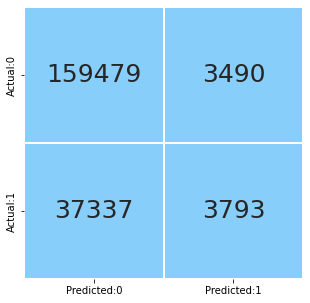

In [63]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
plt.figure(figsize= (5,5))
cm = confusion_matrix(y_test, y_pred)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 10)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 10)

# display the plot
plt.show()

In [64]:
accuracy_table = classification_report(y_test,y_pred)
print(accuracy_table)

              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89    162969
         1.0       0.52      0.09      0.16     41130

    accuracy                           0.80    204099
   macro avg       0.67      0.54      0.52    204099
weighted avg       0.75      0.80      0.74    204099



### Decision tree

In [60]:
classif=DecisionTreeClassifier(class_weight='balanced')
prams={
'max_depth':[1,5,10,50],
'min_samples_split':[5,10,50,100,200]
}
random_classif=RandomizedSearchCV(classif,param_distributions=prams,verbose=3,n_jobs=4, cv=3, scoring='f1_micro')
random_classif.fit(X_train, y_train)
random_classif.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'min_samples_split': 5, 'max_depth': 50}

In [66]:
clf=DecisionTreeClassifier(max_depth=4, min_samples_split=5, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[0 0 0 1 1 1 1 1 0 1]
F1 Score: 0.38478628350639943
AUC score: 0.5974198591840408
              precision    recall  f1-score   support

           0       0.23      0.97      0.37     38179
           1       0.97      0.24      0.38    165920

    accuracy                           0.38    204099
   macro avg       0.60      0.60      0.38    204099
weighted avg       0.83      0.38      0.38    204099



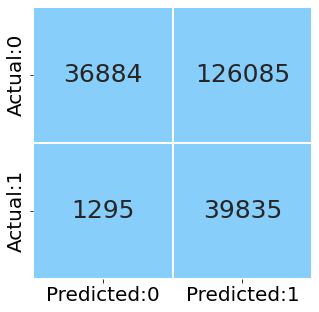

In [67]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, y_pred)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 20)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 20)

# display the plot
plt.show()

In [69]:
from sklearn.metrics import roc_curve

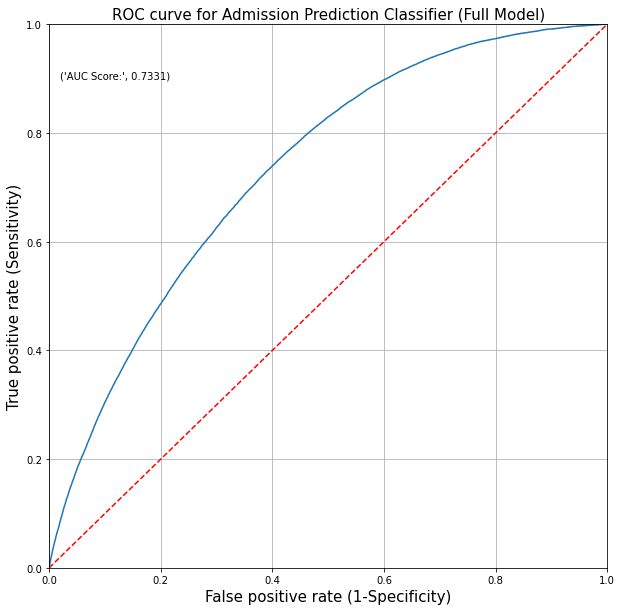

In [71]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize = (10,10))
# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_prob),4)))
                               
# plot the grid
plt.grid(True)

### Random forest

In [62]:
classif= RandomForestClassifier(class_weight='balanced')
classif.fit(X_train, y_train)

prams={
'max_depth':[2,3,5,10],
'n_estimators':[10,50,100,200,300,500],
'min_samples_split':[2,5,10]
}
random_classif=RandomizedSearchCV(classif,param_distributions=prams,verbose=3, cv=3, scoring='f1_micro')
random_classif.fit(X_train, y_train)
random_classif.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=3, min_samples_split=5, n_estimators=500;, score=0.631 total time= 3.6min
[CV 2/3] END max_depth=3, min_samples_split=5, n_estimators=500;, score=0.621 total time= 3.6min
[CV 3/3] END max_depth=3, min_samples_split=5, n_estimators=500;, score=0.630 total time= 3.5min
[CV 1/3] END max_depth=2, min_samples_split=2, n_estimators=200;, score=0.622 total time= 1.0min
[CV 2/3] END max_depth=2, min_samples_split=2, n_estimators=200;, score=0.622 total time= 1.1min
[CV 3/3] END max_depth=2, min_samples_split=2, n_estimators=200;, score=0.620 total time= 1.0min
[CV 1/3] END max_depth=2, min_samples_split=5, n_estimators=100;, score=0.599 total time=  31.5s
[CV 2/3] END max_depth=2, min_samples_split=5, n_estimators=100;, score=0.614 total time=  31.1s
[CV 3/3] END max_depth=2, min_samples_split=5, n_estimators=100;, score=0.595 total time=  31.1s
[CV 1/3] END max_depth=3, min_samples_split=2, n_estimators=50;, s

KeyboardInterrupt: 

In [72]:
h

[0 0 0 0 1 1 1 0 0 0]
F1 Score: 0.4582295844577972
AUC score: 0.6825441272903392
              precision    recall  f1-score   support

           0       0.62      0.91      0.73    111091
           1       0.75      0.33      0.46     93008

    accuracy                           0.64    204099
   macro avg       0.68      0.62      0.60    204099
weighted avg       0.68      0.64      0.61    204099



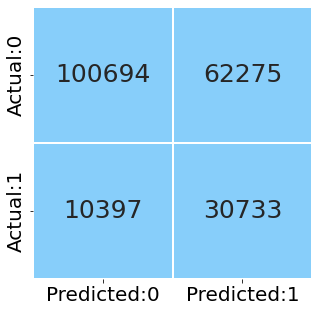

In [73]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, y_pred)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 20)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 20)

# display the plot
plt.show()

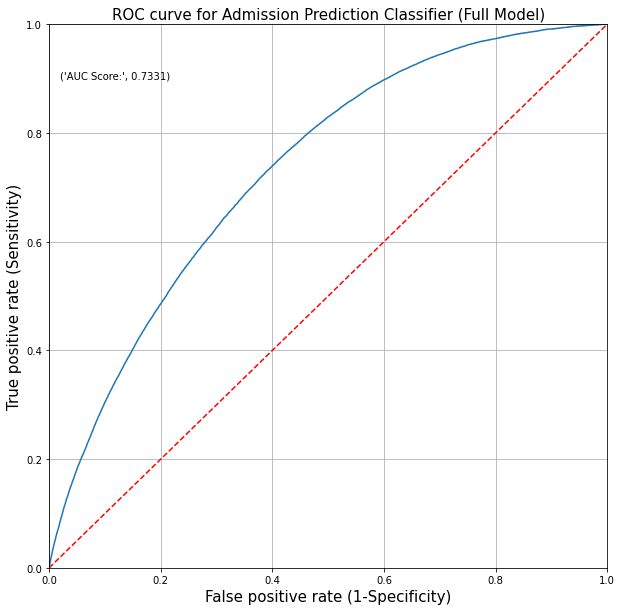

In [74]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize = (10,10))
# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_prob),4)))
                               
# plot the grid
plt.grid(True)

In [ ]:
clf= XGBClassifier()
prams={
'max_depth':[3,5,10],
'n_estimators':[10,50,100,200,300,500,1000],
'colsample_bytree':[0.1,0.5,1],
'subsample':[0.1,0.5,1],
'learning_rate':[0.01,0.05,0.1,0.2]
}
random_clf=RandomizedSearchCV(clf,param_distributions=prams,verbose=3, cv=3, scoring='f1_micro')
random_clf.fit(X_train, y_train)
random_clf.best_params_

In [75]:
clf= XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1,colsample_bytree=0.5, subsample=1)
clf.fit(X_train, y_train)
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[18:43:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 0 0 0 1 1 0 1 0 0]
F1 Score: 0.6982745036243303
AUC score: 0.8543839352925583
              precision    recall  f1-score   support

           0       0.85      0.96      0.90    143693
           1       0.86      0.59      0.70     60406

    accuracy                           0.85    204099
   macro avg       0.85      0.77      0.80    204099
weighted avg       0.85      0.85      0.84    204099



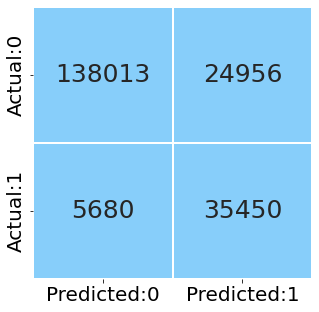

In [76]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, y_pred)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 20)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 20)

# display the plot
plt.show()

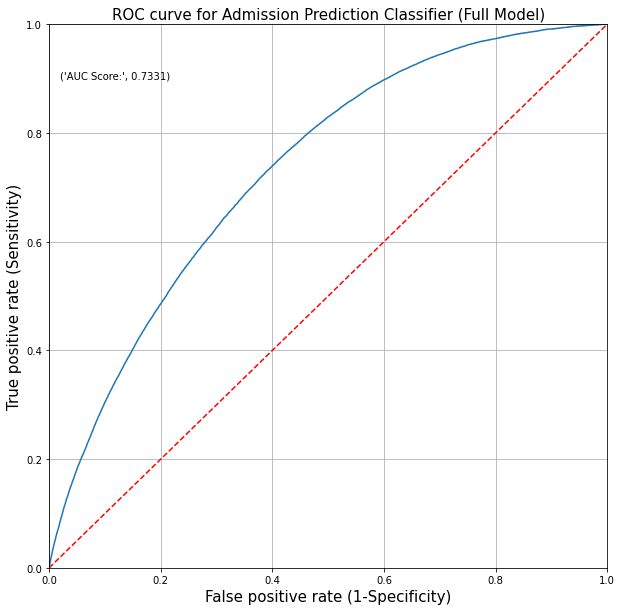

In [77]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize = (10,10))
# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_prob),4)))
                               
# plot the grid
plt.grid(True)

In [66]:
import lightgbm as lgb

AttributeError: module 'graphviz.backend' has no attribute 'ENCODING'

#### Adaboost

In [68]:
classif= AdaBoostClassifier(n_estimators=1000, learning_rate=0.2)
classif.fit(X_train, y_train)
y_pred = (classif.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[1 1 1 1 1 1 1 1 1 1]
F1 Score: 0.3354415668619943
AUC score: 0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.20      0.34    204099

    accuracy                           0.20    204099
   macro avg       0.50      0.10      0.17    204099
weighted avg       1.00      0.20      0.34    204099



### Aproiori algorithm

In [69]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [71]:
order_products = order_products_prior.append(order_products_train)
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [72]:
order_products.shape

(33819106, 4)

In [73]:
order_products['product_id'].nunique()

49685

#### selecting the top 100 frequently ordered products over the total 49685 product

In [74]:
product_count = order_products.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id' : 'no_of_orders_placed'})
product_count = product_count.sort_values('no_of_orders_placed',ascending = False)[0 : 100].reset_index(drop = True)
product_count = product_count.merge(df_products,on = 'product_id',how = 'left')

In [75]:
top_products = list(product_count.product_id)

In [76]:
top_products[1: 20]

[13176,
 21137,
 21903,
 47209,
 47766,
 47626,
 16797,
 26209,
 27845,
 27966,
 22935,
 24964,
 45007,
 39275,
 49683,
 28204,
 5876,
 40706,
 8277]

In [77]:
order_products = order_products[order_products.product_id.isin(top_products)]
order_products.shape

(7795471, 4)

In [78]:
order_products = order_products.merge(df_products,on = 'product_id',how = 'left')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,28985,2,1,Michigan Organic Kale,83,4
1,2,17794,6,1,Carrots,83,4
2,3,24838,2,1,Unsweetened Almondmilk,91,16
3,3,21903,4,1,Organic Baby Spinach,123,4
4,3,46667,6,1,Organic Ginger Root,83,4


In [79]:
cart = order_products.groupby(['order_id', 'product_name'])['reordered'].count().unstack().reset_index().fillna(0).set_index('order_id')
cart.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
del product_count, df_products, order_products, order_products_prior, order_products_train

#### encoding the values

In [82]:
def encode_values(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
cart = cart.applymap(encode_values)
cart.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
cart.size

244498200

In [84]:
cart.shape

(2444982, 100)

In [85]:
frequent_items = apriori(cart, min_support=0.01, use_colnames=True, low_memory=True)
frequent_items.head()

C:\Users\ADMIN\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.016062,(100% Raw Coconut Water)
1,0.025814,(100% Whole Wheat Bread)
2,0.015800,(2% Reduced Fat Milk)
3,0.035694,(Apple Honeycrisp Organic)
4,0.029101,(Asparagus)


In [86]:
frequent_items.tail()

,support,itemsets
124,0.010235,"(Organic Strawberries, Organic Blueberries)"
125,0.010966,"(Organic Hass Avocado, Organic Raspberries)"
126,0.017314,"(Organic Hass Avocado, Organic Strawberries)"
127,0.014533,"(Organic Strawberries, Organic Raspberries)"
128,0.010130,"(Organic Strawberries, Organic Whole Milk)"


In [87]:
frequent_items.shape

(129, 2)

In [98]:
test_data.shape

(562360, 12)

In [99]:
test_data.user_id.nunique()

3576

In [79]:
X_test.shape

(204099, 11)

In [ ]:
test_pred = (clf.predict_proba(test_data)[:,1] >= 0.21).astype(int)
print(test_pred[0:10])

In [83]:
#Save the prediction at a new column in the data_test
test_data['prediction'] = test_pred
test_data.head(10)

,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,prediction
0,68,5,10,30.0,39275,4,6,0.271429,0.641656,51.0,0.666667,0
1,68,5,10,30.0,5991,4,6,0.271429,0.485804,51.0,0.500000,0
2,68,5,10,30.0,26384,16,6,0.271429,0.635231,51.0,0.500000,0
3,68,5,10,30.0,47209,4,6,0.271429,0.790203,51.0,1.000000,0
4,68,5,10,30.0,40706,4,6,0.271429,0.662503,51.0,1.000000,0
5,68,5,10,30.0,22528,6,6,0.271429,0.571429,51.0,1.000000,0
6,68,5,10,30.0,27521,4,6,0.271429,0.698603,51.0,0.333333,1
7,68,5,10,30.0,21413,6,6,0.271429,0.476923,51.0,1.000000,0
8,68,5,10,30.0,26940,4,6,0.271429,0.570131,51.0,1.000000,0
9,68,5,10,30.0,16848,20,6,0.271429,0.519608,51.0,1.000000,0


In [84]:
final_data= test_data.reset_index()
final_data.head()

,index,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,department_id,order_count_per_user,user_reorder_ratio,product_reorder_rate,avg_unique_prod_user,user_prod_reorder_rate_day,prediction
0,0,68,5,10,30.0,39275,4,6,0.271429,0.641656,51.0,0.666667,0
1,1,68,5,10,30.0,5991,4,6,0.271429,0.485804,51.0,0.500000,0
2,2,68,5,10,30.0,26384,16,6,0.271429,0.635231,51.0,0.500000,0
3,3,68,5,10,30.0,47209,4,6,0.271429,0.790203,51.0,1.000000,0
4,4,68,5,10,30.0,40706,4,6,0.271429,0.662503,51.0,1.000000,0


In [85]:
final_data.shape

(562360, 13)

In [86]:
final_data= final_data[['user_id', 'product_id', 'prediction']]
final_data.head()

,user_id,product_id,prediction
0,68,39275,0
1,68,5991,0
2,68,26384,0
3,68,47209,0
4,68,40706,0


In [88]:
# get all order_id from test set
order_test= df_orders[df_orders['eval_set']=='test']
order_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [89]:
order_test= order_test[['user_id', 'order_id']]
order_test

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845
...,...,...
3420918,206202,2728930
3420929,206204,350108
3421001,206206,1043943
3421018,206207,2821651


In [90]:
final_data = final_data.merge(order_test, on='user_id',how='left' )
final_data

,user_id,product_id,prediction,order_id
0,68,39275,0,3024191
1,68,5991,0,3024191
2,68,26384,0,3024191
3,68,47209,0,3024191
4,68,40706,0,3024191
...,...,...,...,...
562355,206092,47766,0,2621891
562356,206092,9076,0,2621891
562357,206092,24184,0,2621891
562358,206092,38293,0,2621891


In [91]:
final_data.isna().any()

user_id       False
product_id    False
prediction    False
order_id      False
dtype: bool

In [92]:
final_data['product_id'] = final_data.product_id.astype(int)
# del orders
# del order_test
# gc.collect()
final_data

,user_id,product_id,prediction,order_id
0,68,39275,0,3024191
1,68,5991,0,3024191
2,68,26384,0,3024191
3,68,47209,0,3024191
4,68,40706,0,3024191
...,...,...,...,...
562355,206092,47766,0,2621891
562356,206092,9076,0,2621891
562357,206092,24184,0,2621891
562358,206092,38293,0,2621891


In [93]:
final_data=final_data.drop('user_id', axis=1)
final_data

,product_id,prediction,order_id
0,39275,0,3024191
1,5991,0,3024191
2,26384,0,3024191
3,47209,0,3024191
4,40706,0,3024191
...,...,...,...
562355,47766,0,2621891
562356,9076,0,2621891
562357,24184,0,2621891
562358,38293,0,2621891


In [94]:
final_data['order_id'].nunique()

3576

In [95]:
submission= dict() # creating an empty dictionary

for row in final_data.itertuples(): #for each row in dataframe
    if row.prediction==1: #if for an order_id and a product_id the prediction is 1.
        try:
            submission[row.order_id] += ' '+str(row.product_id)
        except:
            submission[row.order_id]= str(row.product_id)
            #include it in the order_id keys' value.
    
#the order_id not occuring in our dictionary means no products were reordered for that order, hence None.     
for order in final_data.order_id: 
    if order not in submission:
        submission[order]= 'None'

#submission

In [96]:
submission= pd.DataFrame(submission.items(), columns=['order_id', 'products'])

submission.head(10)

,order_id,products
0,3024191,27521 34199 30391 30233 10644 39275 36418 4917...
1,2986791,12023 13176 30450 2966 16521 12023 2966 21903 ...
2,3241020,21709 21709
3,3116687,16096 43511 31981 16096 25860 42895 39979 4351...
4,2557552,2809 1468 2809 1468 24852 2809
5,1619858,4605 47626 24964 47626 24964
6,2580369,47766 35939 35939
7,524582,27845 27845 27845 27845 27845 27845 27845 2784...
8,362619,28836 39046 4981 28836 28836 37776 28836 4981 ...
9,1519990,21709 42736 24852 27086 5134 42736 27086
